<a href="https://colab.research.google.com/github/cindyhps/analisa_sent_3label/blob/main/analytic_sent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Library

In [48]:
!pip install gcsfs==2024.9.0

  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.6.1-py3-none-any.whl (177 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0


In [49]:
!pip install fsspec==2024.9.0

  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.9.0 requires fsspec==2024.6.1, but you have fsspec 2024.9.0 which is incompatible.


In [50]:
!pip install transformers datasets emoji -q --use-deprecated=legacy-resolver

In [51]:
!pip install wordcloud matplotlib

In [52]:
import os
import re
import emoji
import torch
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import Dataset
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Dataset

In [54]:
!wget -q https://storage.googleapis.com/babak-dataset/indonlu/smsa_doc-sentiment-prosa/train_preprocess.tsv
!wget -q https://storage.googleapis.com/babak-dataset/indonlu/smsa_doc-sentiment-prosa/valid_preprocess.tsv

In [55]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
#unzip data
zip_path = '/content/drive/My Drive/indonlu/indonlu-master.zip'
extract_to = '/content/drive/My Drive/indonlu'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

extracted_files = os.listdir(extract_to)
print("Extracted Files:", extracted_files)

Extracted Files: ['indonlu-master.zip', 'indonlu-master', 'trained_model']


In [57]:
base_path = "/content/drive/My Drive/indonlu/indonlu-master/"
for root, dirs, files in os.walk(base_path):
    print(f"Folder: {root}")
    for file in files:
        print(f"File: {file}")

Folder: /content/drive/My Drive/indonlu/indonlu-master/
File: README.id.md
File: .gitignore
File: CONTRIBUTING.md
File: LICENSE
File: CODE_OF_CONDUCT.md
File: README.md
File: main.py
File: predict.py
File: predict.sh
File: requirements.txt
File: run_all_tasks.sh
File: run_single_task.sh
Folder: /content/drive/My Drive/indonlu/indonlu-master/.github
File: ISSUE_TEMPLATE.md
File: PULL_REQUEST_TEMPLATE.md
Folder: /content/drive/My Drive/indonlu/indonlu-master/data_utils_notebook
File: aspect_based_sentiment_analysis.ipynb
File: ner_data_utils.ipynb
File: aspect_extraction_data_util.ipynb
File: postag_data_utils.ipynb
Folder: /content/drive/My Drive/indonlu/indonlu-master/dataset
Folder: /content/drive/My Drive/indonlu/indonlu-master/dataset/bapos_pos-idn
File: test_preprocess.txt
File: test_preprocess_masked_label.txt
File: train_preprocess.txt
File: valid_preprocess.txt
File: vocab.txt
File: vocab_uncased.txt
Folder: /content/drive/My Drive/indonlu/indonlu-master/dataset/casa_absa-prosa


In [58]:
from google.colab import files
# Upload file
uploaded = files.upload()

Saving test_preprocess.tsv to test_preprocess (1).tsv
Saving test_preprocess_masked_label.tsv to test_preprocess_masked_label (1).tsv
Saving train_preprocess.tsv to train_preprocess (1).tsv
Saving valid_preprocess.tsv to valid_preprocess (1).tsv
Saving vocab.txt to vocab (1).txt
Saving vocab_uncased.txt to vocab_uncased (1).txt


In [59]:
print("Current working directory:", os.getcwd())

Current working directory: /content


In [60]:
print("Files in the current directory:", os.listdir())

Files in the current directory: ['.config', 'vocab_uncased.txt', 'drive', 'valid_preprocess.tsv', 'results', 'train_preprocess (1).tsv', 'test_preprocess.tsv', 'test_preprocess (1).tsv', 'vocab (1).txt', 'test_preprocess_masked_label.tsv', 'train_preprocess.tsv', 'logs', 'test_preprocess_masked_label (1).tsv', 'wandb', 'vocab_uncased (1).txt', 'vocab.txt', 'valid_preprocess (1).tsv', 'sample_data']


In [61]:
train_df = pd.read_csv("/content/train_preprocess.tsv", sep="\t", names=["text", "label"])
valid_df = pd.read_csv("/content/valid_preprocess.tsv", sep="\t", names=["text", "label"])

In [62]:
label_map = {"positive": 0, "neutral": 1, "negative": 2}
train_df["label"] = train_df["label"].map(label_map)
valid_df["label"] = valid_df["label"].map(label_map)

In [63]:
test_df = pd.read_csv("test_preprocess.tsv", sep="\t", names=["text", "label"])
test_df["label"] = test_df["label"].map(label_map)

Preprocessing Data

In [64]:
def preprocess_text(text):
    # Convert emoticons to text (emoji description)
    text = emoji.demojize(text, delimiters=(" ", " "))
    # Lowercasing
    text = text.lower()
    return text

In [65]:
train_df["text"] = train_df["text"].apply(preprocess_text)
valid_df["text"] = valid_df["text"].apply(preprocess_text)

In [66]:
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)

In [67]:
test_df["text"] = test_df["text"].apply(preprocess_text)
test_dataset = Dataset.from_pandas(test_df)
test_dataset = test_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.remove_columns(["text"])

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Load Pretrained Model (IndoBERT)

In [68]:
model_name = "indobenchmark/indobert-base-p1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenisasi

In [69]:
# Tokenisasi dataset
def tokenize_data(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize_data, batched=True)
valid_dataset = valid_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/11000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

In [70]:
# Hapus kolom teks yang tidak diperlukan
train_dataset = train_dataset.remove_columns(["text"])
valid_dataset = valid_dataset.remove_columns(["text"])

In [71]:
# Tentukan data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Training

In [72]:
training_args = TrainingArguments(
    fp16=True,
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [73]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": accuracy, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

<ipython-input-73-2fa03b4a421a>:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [74]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.219700,0.229051,0.930952,0.930059
2,0.137300,0.212997,0.938889,0.938549
3,0.086700,0.253491,0.938889,0.938542
4,0.023700,0.381172,0.935714,0.935447
5,0.012100,0.419928,0.938095,0.937700
6,0.017900,0.461681,0.935714,0.935701
7,0.000400,0.505872,0.936508,0.936433
8,0.000000,0.464749,0.941270,0.940952
9,0.000000,0.507260,0.938095,0.937884
10,0.002300,0.513430,0.937302,0.937112


TrainOutput(global_step=6880, training_loss=0.05056163075943153, metrics={'train_runtime': 1208.9871, 'train_samples_per_second': 90.985, 'train_steps_per_second': 5.691, 'total_flos': 7235618987520000.0, 'train_loss': 0.05056163075943153, 'epoch': 10.0})

Prediksi

In [75]:
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

Evaluasi

In [76]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.464749276638031, 'eval_accuracy': 0.9412698412698413, 'eval_f1': 0.9409519203714527, 'eval_runtime': 2.3799, 'eval_samples_per_second': 529.441, 'eval_steps_per_second': 33.195, 'epoch': 10.0}


{'eval_loss': 0.464749276638031, 'eval_accuracy': 0.9412698412698413, 'eval_f1': 0.9409519203714527, 'eval_runtime': 2.7209, 'eval_samples_per_second': 463.082, 'eval_steps_per_second': 29.035, 'epoch': 10.0}
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       735
           1       0.89      0.81      0.85       131
           2       0.91      0.95      0.93       394

    accuracy                           0.94      1260
   macro avg       0.92      0.91      0.91      1260
weighted avg       0.94      0.94      0.94      1260



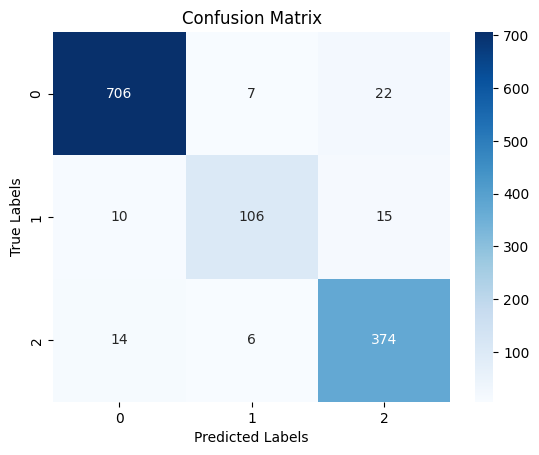

In [77]:
# Evaluasi
results = trainer.evaluate()
print(results)

# Prediksi pada data validasi
predictions = trainer.predict(valid_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Classification report
print(classification_report(valid_dataset["label"], predicted_labels))

# Confusion matrix
cm = confusion_matrix(valid_dataset["label"], predicted_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Visualisasi

In [78]:
all_text = " ".join(train_df["text"].tolist())

In [93]:
stopwords = set(STOPWORDS)
stopwords.update(["yang", "dan", "di", "dengan", "untuk", "ini", "itu", "pada", "dari", "ke", "adalah", "akan", "ada", "bisa", "tersebut", "oleh", "karena", "menjadi", "sebagai", "nya"])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="viridis",
    max_words=200,
    contour_color="steelblue",
    contour_width=2,
    stopwords=stopwords  # Tambahkan stopwords
).generate(all_text)

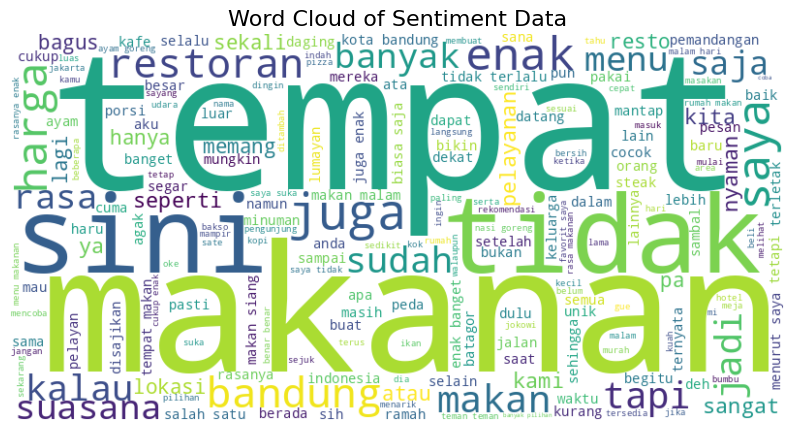

In [94]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Sentiment Data", fontsize=16)
plt.show()

In [95]:
# Pisahkan teks berdasarkan label
positive_text = " ".join(train_df[train_df["label"] == 0]["text"].tolist())
neutral_text = " ".join(train_df[train_df["label"] == 1]["text"].tolist())
negative_text = " ".join(train_df[train_df["label"] == 2]["text"].tolist())

In [98]:
def create_wordcloud(text, title):
    stopwords = set(STOPWORDS)
    stopwords.update(["yang", "dan", "di", "dengan", "untuk", "ini", "itu", "pada", "dari", "ke", "adalah", "akan", "ada", "bisa", "tersebut", "oleh", "karena", "menjadi", "sebagai", "nya"])

    # Tentukan colormap berdasarkan judul
    if "Positive" in title:
        colormap = "Greens"  # Dominan hijau untuk positif
    elif "Negative" in title:
        colormap = "Reds"    # Dominan merah untuk negatif
    else:
        colormap = "Greys"   # Dominan abu-abu untuk netral

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap=colormap,        # Gunakan colormap yang ditentukan
        max_words=200,
        contour_color="steelblue",
        contour_width=2,
        stopwords=stopwords
    ).generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

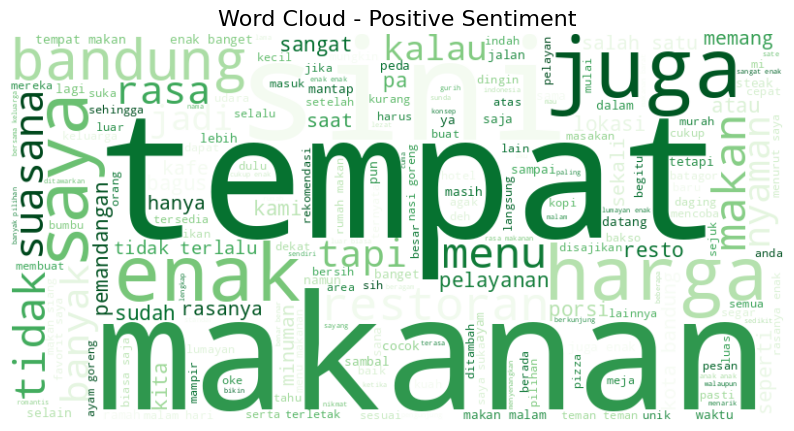

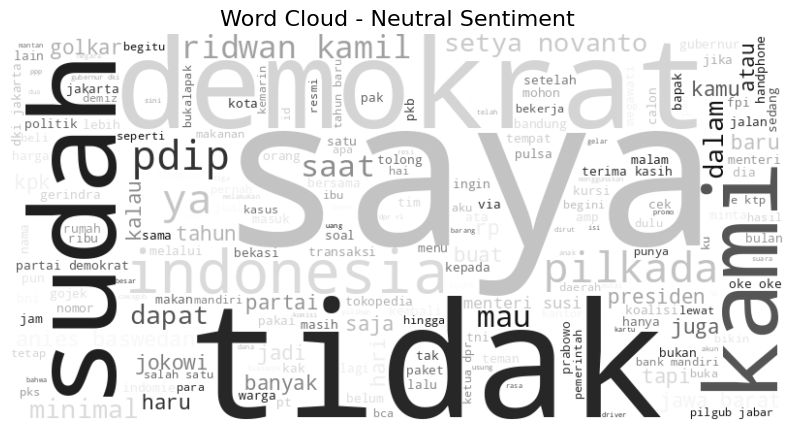

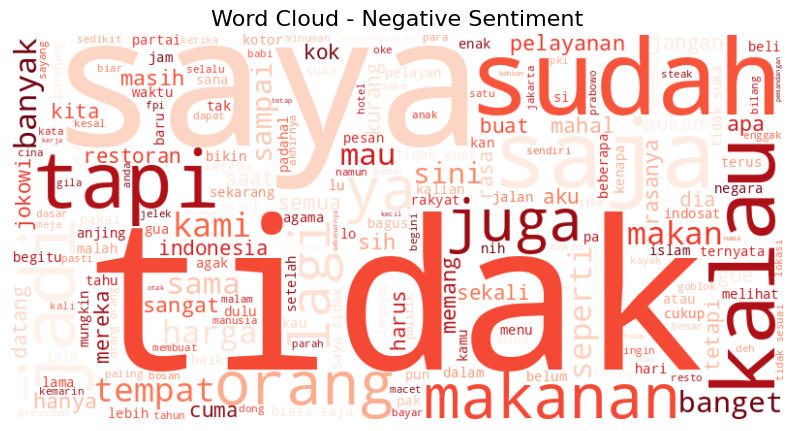

In [99]:
# Buat wordcloud untuk setiap label
create_wordcloud(positive_text, "Word Cloud - Positive Sentiment")
create_wordcloud(neutral_text, "Word Cloud - Neutral Sentiment")
create_wordcloud(negative_text, "Word Cloud - Negative Sentiment")

Save Model

In [100]:
trainer.save_model("/content/drive/My Drive/indonlu/trained_model")

Test Model

In [101]:
# Prediksi pada data test
predictions = trainer.predict(test_dataset) # Changed to use test_dataset
predicted_labels = np.argmax(predictions.predictions, axis=1)

In [102]:
# Evaluasi
accuracy = accuracy_score(test_dataset["label"], predicted_labels)
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

Accuracy on test data: 92.20%
